In [2]:
%matplotlib inline

import torch
import numpy as np
import torch.nn as nn # CTCLoss, Linear, Module, LSTM, Conv1d, ReLU, Dropout, Sigmoid, Tanh, RNN, LSMT#, LogSoftmax
from torch.nn.functional import log_softmax, softmax
from torch.utils.data import Dataset, DataLoader
import torchvision
from torch import optim
from time import time
import math
import os

import matplotlib.pyplot as plt
from pathlib import Path
from helper import load_data_etc, load_adj_matrix_etc

In [3]:
# NOTE: if can't open .npz file, must trust notebook first
root = Path(".")
data_file = root / "data_etc.npz"
res_dict = load_data_etc(str(data_file))

adj_file = root / "adj_matrix_etc.npz"
adj_dict = load_adj_matrix_etc(str(adj_file))

In [23]:
class MyDataset(Dataset):
    def __init__(self, X, window = 100):
        self.X = X
        self.window = window

    def __len__(self):
        return len(self.X) - (self.window + 1) + 1

    def __getitem__(self, index):
#         return torch.tensor(self.X[index : index + self.window]).unsqueeze(0), torch.tensor(self.X[index + 1 : index + self.window + 1]).unsqueeze(0)
        return np.expand_dims(self.X[index : index + self.window], axis=0), np.expand_dims(self.X[index + 1 : index + self.window + 1], axis=0)
def collate_train(batch_data):
    X = []
    Y = []
    for tup in batch_data:
        X.append(tup[0])
        Y.append(tup[1])
    X = np.concatenate(X, axis=0)
    Y = np.concatenate(Y, axis=0)
    
    # fill the NaN values with the average of existing values in array
    X = np.nan_to_num(X, nan=np.mean(X[X==X]))
    Y = np.nan_to_num(Y, nan=np.mean(Y[Y==Y]))
    
    X = torch.DoubleTensor(X) #, dtype=torch.double)
    Y = torch.DoubleTensor(Y) #, dtype=torch.double)
#     assert(not torch.isnan(X).any())
    return X, Y

'''
data: numpy array of data
train_split: percentage used for train
window: time series length
'''
def train_dev_split_random(data, train_split, window=15, random=False):
    print(data.shape)
    # create list of sections
    
    sequences = []
    for i in range(len(data)//window):
        sequences.append(data[i*window:(i+1)*window])

    # randomly select sections for dev
    dev_sequences = []
    n_dev_sequences = math.floor((len(data)/window)*(1-train_split))
    for j in range(n_dev_sequences):
        if random:
            index = torch.randint(0, len(sequences), (1,)).item()
        else:
            index=-j
        dev_sequences.append(sequences[index])
        sequences = sequences[:index] + sequences[index+1:]

    return sequences, dev_sequences

def train_dev_split_startend(data, train_ratio, window=15):
    # randomly select sections for dev
    n_dev_sequences = math.floor((len(data)/window)*(1-train_ratio))*window
    dev_split = data[-(n_dev_sequences+1):] # shifted by 1 for one more timestep label
    train_split = data[:-(n_dev_sequences+1)]

    return train_split, dev_split

def get_loaders(batchsize, collatefn):
    train_split, dev_split = train_dev_split_startend(res_dict['data'], 0.9, window=WINDOW)
    train_dataset = MyDataset(train_split, window=WINDOW)
    train_loader_args = dict(shuffle=True, batch_size=batchsize, num_workers=numworkers, pin_memory=True, collate_fn=collatefn) if cuda else dict(shuffle=True, batch_size=batchsize, collate_fn=collate_train)
    train_loader = DataLoader(train_dataset, **train_loader_args)

    dev_dataset = MyDataset(dev_split, window=WINDOW)
    dev_loader = DataLoader(dev_dataset, **train_loader_args)
    
    return train_loader, dev_loader, train_split.shape[0]

def get_datasets():
    train_split, dev_split = train_dev_split_startend(res_dict['data'], 0.9, window=WINDOW)
    train_dataset = MyDataset(train_split, window=WINDOW)
    dev_dataset = MyDataset(dev_split, window=WINDOW)
    return train_dataset, dev_dataset

## Loss

In [5]:
class Loss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, std, mean, y):
        """
        Maximizing Negative Log-Likelihood Loss(y|mean,std**2)
        Args:
            std: standard deviation per sensor (output from model)
            mean: mean per sensor (output from model)
            y: ground truth data that should be be contained within the normal distribution
        """
        variance = std**2 + 1e-10 # add epsilon so no log(0)
        batchsize = y.shape[0]
        n = y.shape[3] # n lanes for each sensor

        distance_squared_sum = torch.zeros(y[:,:,:,0].shape).to(DEVICE)

        # sum the 4 real data point squared distances from the mean
        for i in range(n):
            distance_squared_sum += (y[:,:,:,i] - mean)**2
        # Loss(y|mean,std**2)
        loss = (n/2)*torch.log(variance)+(1/(2*variance)) * distance_squared_sum
        
        # mean -log likelihood
        loss = loss.mean()
        return loss

In [6]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence

class Model(nn.Module):
    def __init__(self, window, conv_out_channel=512, conv_kernel_size=1, conv_stride=1, hidden_size=512, sensors=200, features=4):
        super(Model, self).__init__()
        self.input_size = sensors*features
        self.conv1d = nn.Conv1d(self.input_size, conv_out_channel, kernel_size=conv_kernel_size, stride=1)
        self.lstm = nn.LSTM(conv_out_channel, hidden_size, num_layers=1, batch_first=True) # num_directions=True
        self.linear_std = nn.Linear(hidden_size, 200)
        self.linear_mean = nn.Linear(hidden_size, 200)
        
    def forward(self, X):
#         assert(not torch.isnan(X).any())
        X = X.reshape((X.shape[0], X.shape[1], self.input_size)).permute(0,2,1)
#         print(X.shape)
        outputs = self.conv1d(X)
#         print(outputs.shape)
        outputs = outputs.permute(0,2,1)
#         print(outputs.shape)
        outputs = self.lstm(outputs)[0]
#         print(outputs.shape)
        std = self.linear_std(outputs)
        mean = self.linear_mean(outputs)
        
        return std, mean

In [7]:
def save_state(val_loss, running_best, model_version, model_number, model, optimizer, criterion, batch_size):
    path = './models/model_' + str(model_version) + '_'+str(model_number)
    if not os.path.isdir(path):
        os.makedirs(path)
    torch.save(model, path+'/model.pt')
    # write parameter tracking file
    parameter_file = open(path+'/hyperparameters.txt', 'w')
    parameter_file.write('Validation Loss:\n' + str(val_loss))
    parameter_file.write('\nRunning Best Validation Loss:\n' + str(running_best[0]) + "  " + str(running_best[1]))
    parameter_file.write('\nbatch_size:\n' + str(batch_size))
    parameter_file.write('\nOptimizer:\n' + str(optimizer))
    parameter_file.write('\nCriterion:\n' + str(criterion))
    parameter_file.write('\nModel:\n' + str(model))
    parameter_file.close()
    
def validate(model, loader):
    model.eval()
    with torch.no_grad():
        running_loss = 0
        for i, (x,y) in enumerate(loader):
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            std, mean = model(x)

            running_loss += criterion(std, mean, y).detach().item()

            print("Validation iteration {}                                  ".format(i), end='\r')

    model.train()
    return running_loss/(i+1)

In [18]:
model_version = 1 # <============================ ALWAYS CHECK THIS ==============================<<<<<<
WINDOW = 100 # change to 20 for short term predictions?
EPOCHS = 50
cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")
numworkers = 4 if cuda else 0 # FIX
batchsize = 32 if cuda else 64
train_loader, dev_loader, LEN_TRAIN = get_loaders(batchsize, collate_train)

model = Model(WINDOW, hidden_size=512).double().to(DEVICE)

optimizer = optim.Adam(model.parameters(),lr=0.001)#, weight_decay=1e-6)
#optim.SGD(model.parameters(), lr=15, momentum=0.9, weight_decay=5e-6)
mile_stones = [30]
gamma = 0.1
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=mile_stones, gamma=gamma)
criterion = Loss()

## Training

In [ ]:
running_loss = 0 
running_best = ['', 1e10]
model_number = 0 # CHECK THIS <<=================<<<<<
train_loss = []
predict_loss = []
for epoch in range(EPOCHS):
    model.train()
    ti = time()
    for i, (x,y) in enumerate(train_loader):
#         if i == 1:
#             break
        _ti = time()
        # print(i,x.shape,y.shape)
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        optimizer.zero_grad()
#         print(x.dtype)
        std, mean = model(x)

        loss = criterion(std, mean, y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.detach().item()
        
        _tf = time()
        print('Epoch:', epoch, '| Iteration:', i, '| Loss', running_loss/(i+1), '| Projected Time Left', int(((LEN_TRAIN//batchsize)-(i+1))*(_tf-_ti)), '| Projected Time Total', int(((LEN_TRAIN//batchsize))*(_tf-_ti)),'   ', end='\r')
    
        torch.cuda.empty_cache()

    val_loss = validate(model, dev_loader)
    print("Epoch", epoch, "Loss:", running_loss/(i+1), "Val Loss:", val_loss, "                                          ")
    if running_best[1] > val_loss:
        running_best[0] = 'Model_' + str(model_version) + '_' + str(model_number)
        running_best[1] = val_loss
    print("Time for Epoch:", time() - ti)
    print("\tRunning Best:", *running_best)
    print()
    scheduler.step()
    
    save_state(val_loss, running_best, model_version, model_number, model, optimizer, criterion, batchsize)
    
    train_loss.append(running_loss/(i+1))
    predict_loss.append(val_loss)
    
    model_number += 1


Epoch 0 Loss: 31718323.79154318 Val Loss: 7388.36660783606                                          5       
Time for Epoch: 271.8977494239807
	Running Best: Model_1_0 7388.36660783606

Epoch 1 Loss: 31723581.72202013 Val Loss: 4536.572662675116                                                 
Time for Epoch: 272.9719979763031
	Running Best: Model_1_1 4536.572662675116

Epoch 2 Loss: 31727086.96656804 Val Loss: 3226.6089935330992                                                
Time for Epoch: 274.28747487068176
	Running Best: Model_1_2 3226.6089935330992

Epoch 3 Loss: 31729638.258722045 Val Loss: 2386.5400255233985                                               
Time for Epoch: 274.6894326210022
	Running Best: Model_1_3 2386.5400255233985

Epoch 4 Loss: 31731566.64681908 Val Loss: 1857.657296399478                                                 
Time for Epoch: 274.7323591709137
	Running Best: Model_1_4 1857.657296399478

Epoch 5 Loss: 31733079.517732374 Val Loss: 1469.1213451787316  

## Visualizaions

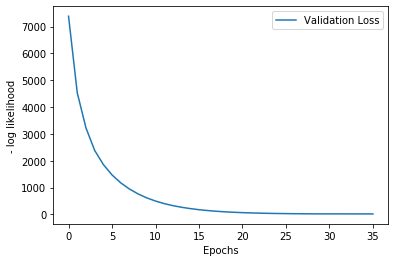

In [16]:
# model_1_
val_loss=[7388.36660783606  ,4536.572662675116 ,3226.6089935330992,2386.5400255233985,1857.657296399478 ,1469.1213451787316,1173.5869356269304,943.7305504040083 ,760.3757738989957 ,612.3988545295364 ,494.6662341250356 ,399.62303351437225,323.4880402866438 ,262.3993834576302 ,212.91304048694346,172.24282749370806,140.25061957067837,113.64035681533792,92.70272145849219 ,75.97388701472428 ,62.45946007828429 ,51.4891792190105  ,42.88241980537515 ,35.9640404178808  ,30.419002505664253,25.999973011320282,22.598323098791024,19.857759655190694,17.75730567485982 ,16.041313188804764,15.912208356443404,15.70160907775858,15.470376344399023,15.234930132134908,14.955722854359525,14.6852866089569]
train_loss=[31718323.79154318 ,31723581.72202013 ,31727086.96656804 ,31729638.258722045,31731566.64681908 ,31733079.517732374,31734282.66694254 ,31735246.5872097  ,31736022.128907647,31736647.708777193,31737153.226737063,31737562.326231014,31737893.841959983,31738162.83696668 ,31738381.401434243,31738559.245347574,31738704.192565918,31738822.594210666,31738919.604253493,31738999.40254868 ,31739065.369198058,31739120.222382598,31739166.15031401 ,31739204.919783216,31739237.95978025 ,31739266.427869007,31739291.257571317,31739313.199263375,31739332.85117729 ,31739350.691390898,31739367.68172534 ,31739384.49925932 ,31739401.114864938,31739417.503205556,31739433.642388243,31739449.514583733]
plt.figure()
# plt.plot(range(len(predict_loss)), train_loss, label="Train Loss")
plt.plot(range(len(val_loss)), val_loss, label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('- log likelihood')
plt.legend()
plt.show()

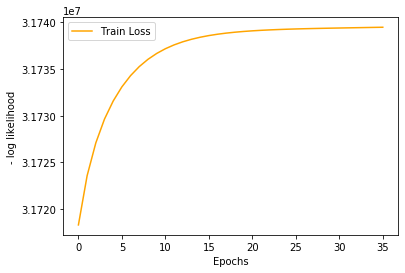

In [19]:
plt.figure()
plt.plot(range(len(val_loss)), train_loss, label="Train Loss", color='orange')
plt.xlabel('Epochs')
plt.ylabel('- log likelihood')
plt.legend()
plt.show()

## Predict

In [100]:
WINDOW = 100
cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")
model_version = 1
model_number =35
path = './models/model_{}_{}/model.pt'.format(model_version, model_number)
model = torch.load(path).to(DEVICE)

In [87]:
def predict(model, loader=None, data_batch=None, lead=99, num_steps=1):
#     if not loader and not data_batch:
#         raise("Must provide a batch of data or a loader.")
    model.eval
    with torch.no_grad():
#         if loader!=None:
#             for i, (x,y) in enumerate(loader):
#                 x=x.to(DEVICE)
#                 y=y.to(DEVICE)
                
#                 print(x.shape)
#                 std, mean = model(x[:,99])
                
#                 return std[:,-num_steps], mean[:,-num_steps]
#         else:
        data_batch=data_batch.to(DEVICE)

        std, mean = model(data_batch)
        return std[:,-num_steps].to('cpu').numpy(), mean[:,-num_steps].to('cpu').numpy()


In [82]:
_, dev_dataset = get_datasets()
x = torch.DoubleTensor(dev_dataset[0][0])
y = torch.DoubleTensor(dev_dataset[0][1])
print(x.shape, y.shape)


torch.Size([1, 100, 200, 4]) torch.Size([1, 100, 200, 4])


In [112]:
std, mean = predict(model, data_batch=x)

print(std.shape,mean.shape)
print('0',mean[0][0], std[0][0])
print('2',mean[0][2], std[0][2])
print('100',mean[0][100], std[0][100])
print('199',mean[0][199], std[0][199])

torch.Size([1, 100, 200])
(1, 200) (1, 200)
0 60.73566654428308 4.6016462639968525
2 63.582710568990734 -8.959671589266371
100 64.96206305161374 4.861819481547735
199 62.8511919144734 6.445876154178205


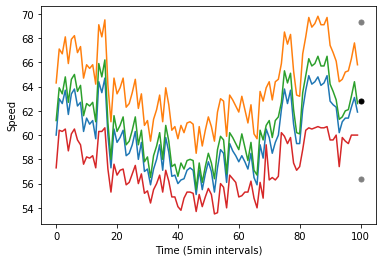

In [110]:
sensor = 199 # 0, 2, 100, 199


inp = x[0,:,0].numpy()
# label = y[0,-1,0]
plt.figure()
plt.plot(range(x.shape[1]), inp)
plt.plot([100],mean[0,sensor], 'o', color='black', markersize=5)
plt.plot([100],mean[0,sensor]+std[0,sensor], 'o', color='grey', markersize=5)
plt.plot([100],mean[0,sensor]-std[0,sensor], 'o', color='grey', markersize=5)


# https://matplotlib.org/gallery/lines_bars_and_markers/errorbar_subsample.html#sphx-glr-gallery-lines-bars-and-markers-errorbar-subsample-py
# y1 = mean[0,0] + std[0,0]
# y2 = mean[0,0] - std[0,0]
# plt.errorbar([100], mean[0,0], yerr=y1)
# plt.errorbar([100], mean[0,0], yerr=y2)

plt.xlabel('Time (5min intervals)')
plt.ylabel('Speed')
plt.show()

In [80]:
std[0,0]

tensor(2.5417, device='cuda:0', dtype=torch.float64)

In [98]:
plt.__version__


AttributeError: module 'matplotlib.pyplot' has no attribute '__version__'

In [99]:
import matplotlib
matplotlib.__version__

'3.1.3'